# Import packages
## Required python3 modules:
- matplotlib
- numpy as np
- pandas
- seaborn
- os
- pickle
- sklearn
- mpl_toolkits

If you are missing any of these packages I would recommend using the following lines in your juypter notebook:
```
import sys
!{sys.executable} -m pip install missing_package_name
```

In [1]:
# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

# Misc. packages
import numpy as np
import pandas as pd
import os
import pickle5 as pickle



# Regressor
from sklearn.ensemble import RandomForestRegressor
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



/var/folders/mx/f74jvlpj38n6rr6k7c9p_l480000gn/T/ipykernel_88812/297096767.py:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


# Files required to run gen_pair.ipynb:
- The angles (106-180 degrees): keys.pickle
- The regression targets Y (pair energies): targets.pickle
- The feature set, X: feats.pickle
- True CASSCF energies: casscf.csv
- True CASPT2 energies: caspt2.csv
- The true correlation energies (E2): E2.csv

In [2]:

# X=pd.read_pickle('feats.pickle')
# Y=pd.read_pickle('targets.pickle')

with open('feats.pickle', 'rb') as handle:
    X = pickle.load(handle)

with open('targets.pickle', 'rb') as handle:
    Y = pickle.load(handle)


with open('keys.pickle', 'rb') as handle:
    keys = pickle.load(handle)




angles=np.arange(106,181,1)
l=keys
l=[i for i in l if float(i)>=110.0 and float(i)<=170.0]
print(f'Number of data points in potential energy curve: {len(l)}')


Number of data points in potential energy curve: 121


In [3]:
# Split the data 70% train/30% test
train_ind,test_ind=train_test_split(l, test_size=0.3, random_state=0)
num_train=[int(i) for i in np.linspace(10,len(train_ind),19)]


X_train=X.loc[train_ind].to_numpy()
X_test=X.loc[test_ind].to_numpy()

y_train=Y[train_ind].T.stack().to_numpy()
y_test=Y[test_ind].T.stack().to_numpy()



In [4]:
caspt2=pd.read_csv('caspt2.csv',index_col='Label').drop(columns='Unnamed: 0')
casscf=pd.read_csv('casscf.csv',index_col='Label').drop(columns='Unnamed: 0').loc[map(float,test_ind)].rename(columns={'SCF':0})
E1Dict=pd.read_csv("E2.csv").rename(columns={'Unnamed: 0':'Label'}).set_index('Label')

In [5]:
# Values across the learning curve 
num_train

[10, 14, 18, 22, 26, 30, 34, 38, 42, 47, 51, 55, 59, 63, 67, 71, 75, 79, 84]

In [6]:
print(f'Number of features: {X_train.shape[1]}')

Number of features: 38


In [7]:
print(f'Number of molecules in the training set: {len(train_ind)} \n Number of molecules in the training set: {len(test_ind)}')

Number of molecules in the training set: 84 
 Number of molecules in the training set: 37


In [8]:
print(f'Number of pair energies in the training set: {len(y_train)} \n Number of pair energies in the training set: {len(y_test)}')

Number of pair energies in the training set: 7896 
 Number of pair energies in the training set: 3478


# First Evaluation Metric
Features are scaled and then a random forest regressor is trained to predict pair energies. 70% of the data for training and 30% for testing.

In [9]:

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
regr = RandomForestRegressor(max_depth=1000,max_features='sqrt',bootstrap=True,oob_score=True,n_estimators=700,random_state =69,n_jobs=-1).fit(X_train_scaled, y_train)
y_train_pred=regr.predict(X_train_scaled)
y_test_pred=regr.predict(X_test_scaled)

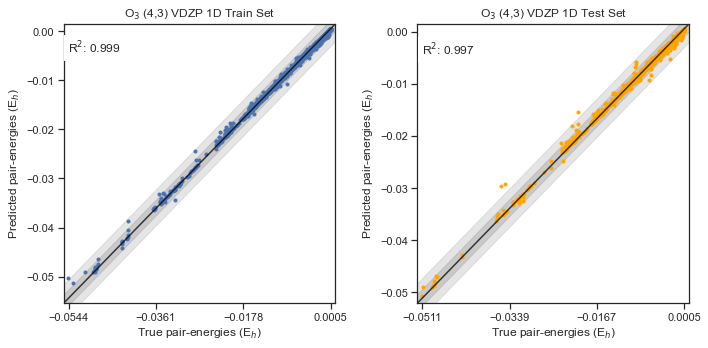

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
fill=np.linspace(min(y_test)-1e-2,max(y_test)+1e-2,20)
plt.plot(fill,fill,color='black',alpha=0.75)
plt.fill_between(fill,fill-0.0016,fill+0.0016,color='gray', alpha=0.3)
plt.fill_between(fill,fill-0.003665,fill+0.003665,color='darkgray', alpha=0.3)

plt.scatter(y_train,y_train_pred,alpha=1,marker='.')
plt.xticks(np.round(np.linspace(min(y_train), max(y_train), 4),4),rotation=0)
plt.text(min(y_train), max(y_train)-5e-3, f'R$^{2}$: {r2_score(y_train,y_train_pred):0.3f}',fontsize=12,bbox=dict(facecolor='white', alpha=1.0))
plt.xlim(min(y_train)-1e-3, max(y_train)+1e-3)
plt.ylim(min(y_train)-1e-3, max(y_train)+1e-3)
plt.xlabel('True pair-energies (E$_{h}$)',fontsize=12)
plt.ylabel('Predicted pair-energies (E$_{h}$)',fontsize=12)
plt.title('O$_{3}$ (4,3) VDZP 1D Train Set',fontsize=12)
plt.subplot(1, 2, 2)
fill=np.linspace(min(y_test)-1e-2,max(y_test)+1e-2,20)
plt.plot(fill,fill,color='black',alpha=0.75)
plt.fill_between(fill,fill-0.0016,fill+0.0016,color='gray', alpha=0.3)
plt.fill_between(fill,fill-0.003665,fill+0.003665,color='darkgray', alpha=0.3)
plt.scatter(y_test,y_test_pred,alpha=1,marker='.',color='orange')
plt.xticks(np.round(np.linspace(min(y_test), max(y_test), 4),4),rotation=0)
plt.text(min(y_test), max(y_test)-5e-3, f'R$^{2}$: {r2_score(y_test,y_test_pred):0.3f}',fontsize=12,bbox=dict(facecolor='white', alpha=1.0))
plt.xlim(min(y_test)-1e-3, max(y_test)+1e-3)
plt.ylim(min(y_test)-1e-3, max(y_test)+1e-3)
plt.xlabel('True pair-energies (E$_{h}$)',fontsize=12)
plt.ylabel('Predicted pair-energies (E$_{h}$)',fontsize=12)
plt.title('O$_{3}$ (4,3) VDZP 1D Test Set',fontsize=12)

plt.tight_layout()
plt.show()

# Test set on the potential energy curve

The pair energies ($\varepsilon_{pq}$) predicted from the test set can then be summed into correlation energies ($E_{2}$):

$$ E_{2}=\sum_{pq} \varepsilon_{pq}$$

In [11]:
pred_train_E2=np.sum(y_train_pred.reshape(len(train_ind),-1),axis=1)
train_E2=np.sum(y_train.reshape(len(train_ind),-1),axis=1)
pred_test_E2=np.sum(y_test_pred.reshape(len(test_ind),-1),axis=1)
test_E2=np.sum(y_test.reshape(len(test_ind),-1),axis=1)

In [12]:
df_PredE2=pd.DataFrame(pred_test_E2,index=map(float,test_ind))

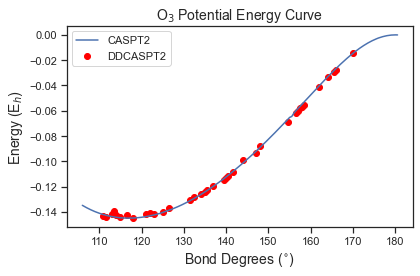

In [13]:
plt.plot(caspt2-caspt2.max().values,label='CASPT2')
plt.scatter(list(map(float,test_ind)),casscf.add(df_PredE2,fill_value=0)-caspt2.max().values,label='DDCASPT2',color='red')
plt.legend()
plt.title(r'O$_{3}$ Potential Energy Curve',fontsize=14)
plt.ylabel('Energy (E$_{h}$)',fontsize=14)
plt.xlabel('Bond Degrees ($^{\circ}$)',fontsize=14)
plt.tight_layout()
plt.show()

# Second Evaluation Metric
Learning curves are used to evaluate the effectiveness of our model with respect to the total correlation energies. The amount of test data is held the same as training set is systematically increased.

In [ ]:
# Create the dataset
rng = np.random.default_rng(42)
# factor_dict=pd.read_excel('factor_dict.xlsx')
R2=[]
MAE=[]
RMSE=[]
kcalMAE=[]
kcalRMSE=[]
Train_R2=[]
Train_MAE=[]
Train_RMSE=[]
Train_kcalMAE=[]
Train_kcalRMSE=[]
Num_Test=[]
Num_Train=[]
for k in num_train:
    TestE2_list=[]
    PredE2_list=[]
    Train_E2_list=[]
    Train_PredE2_list=[]
    testsubs_list=[]
    trainsubs_list=[]


    print(f'Number of Train {k}')
#         trainsubs=random.sample(train_ind, k)
    trainsubs=train_ind[0:k]
    testsubs=test_ind
    Num_Test.append(len(testsubs))
    Num_Train.append(k)
    print(f'Number of test {len(testsubs)}')
#         for typ in ['A','B','C','D','E','F','G','H']:
    
    y=Y
    X_test_stacked=X.loc[testsubs].to_numpy()
    X_train_stacked=X.loc[trainsubs].to_numpy()
    y_test_stacked=y[testsubs].T.stack().to_numpy()
    y_train_stacked=y[trainsubs].T.stack().to_numpy()


    test_labels=testsubs
    train_labels=trainsubs
    scaler = MinMaxScaler().fit(X_train_stacked)
    X_train_scaled = scaler.transform(X_train_stacked)
    X_test_scaled = scaler.transform(X_test_stacked)
    print(X_train_scaled.shape)
#     reg8=KNeighborsRegressor(n_neighbors=int(np.log(len(y[trainsubs[0]]))),leaf_size=1,n_jobs=-1,p=1).fit(X_train_scaled,y_train_stacked)    
    reg8=regr.fit(X_train_scaled,y_train_stacked)
#     reg8=RandomForestRegressor(max_features='sqrt',bootstrap=True,oob_score=True,n_estimators=700,random_state =69,n_jobs=-1).fit(X_train_scaled, y_train_stacked)
    
    print(reg8.get_params)
    y_test_trimpred=reg8.predict(X_test_scaled)
    y_train_trimpred=reg8.predict(X_train_scaled)


    print('pair energies (e\u2082) test R\u00b2: %.4f' %r2_score(y_test_stacked,y_test_trimpred))
    print('pair energies (e\u2082) train R\u00b2: %.4f' %r2_score(y_train_stacked,y_train_trimpred))  
    PredE2=np.sum(y_test_trimpred.reshape(len(testsubs),-1),axis=1)
    TestE2=np.sum(y_test_stacked.reshape(len(testsubs),-1),axis=1)
    Train_PredE2=np.sum(y_train_trimpred.reshape(len(trainsubs),-1),axis=1)
    Train_E2=np.sum(y_train_stacked.reshape(len(trainsubs),-1),axis=1)
    TestE2_list.append(TestE2)
    PredE2_list.append(PredE2)
    Train_E2_list.append(Train_E2)
    Train_PredE2_list.append(Train_PredE2)
    testsubs_list.append(testsubs)
    trainsubs_list.append(trainsubs)
    

    R2.append(r2_score(TestE2,PredE2))
    MAE.append(mean_absolute_error(TestE2,PredE2))
    RMSE.append(np.sqrt(mean_squared_error(TestE2,PredE2)))
    kcalMAE.append(627.5*mean_absolute_error(TestE2,PredE2))
    kcalRMSE.append(627.5*np.sqrt(mean_squared_error(TestE2,PredE2)))

    Train_R2.append(r2_score(Train_E2,Train_PredE2))
    Train_MAE.append(mean_absolute_error(Train_E2,Train_PredE2))
    Train_RMSE.append(np.sqrt(mean_squared_error(Train_E2,Train_PredE2)))
    Train_kcalMAE.append(627.5*mean_absolute_error(Train_E2,Train_PredE2))
    Train_kcalRMSE.append(627.5*np.sqrt(mean_squared_error(Train_E2,Train_PredE2)))

    print('Test E\u2082 MAE: %.4E' % mean_absolute_error(TestE2,PredE2), 'E\u2095')
    print('Test E\u2082 RMSE: %.4E' % np.sqrt(mean_squared_error(TestE2,PredE2)), 'E\u2095','\n')
    print('Test E\u2082 MAE: %.4E' % ((mean_absolute_error(TestE2,PredE2))*627.5), 'kcal/mol')
    print('Test E\u2082 RMSE: %.4E' % (np.sqrt(mean_squared_error(TestE2,PredE2))*627.5), 'kcal/mol','\n')

    print('Train E\u2082 MAE: %.4E' % mean_absolute_error(Train_E2,Train_PredE2), 'E\u2095')
    print('Train E\u2082 RMSE: %.4E' % np.sqrt(mean_squared_error(Train_E2,Train_PredE2)), 'E\u2095','\n')
    print('Train E\u2082 MAE: %.4E' % ((mean_absolute_error(Train_E2,Train_PredE2))*627.5), 'kcal/mol')
    print('Train E\u2082 RMSE: %.4E' % (np.sqrt(mean_squared_error(Train_E2,Train_PredE2))*627.5), 'kcal/mol','\n')
    
#     pd.DataFrame({'TestE2':TestE2,'testsubs':testsubs,'PredE2':PredE2}).to_excel(f'big_scaled_super_4_3_VDZP_Test_Energies.xlsx')
#     pd.DataFrame({'Num_Test':Num_Test,'Num_Train':Num_Train,'Test_R2':R2,'Test_MAE (kcal/mol)':kcalMAE,'Test_RMSE (kcal/mol)':kcalRMSE,'Test_MAE (Eh)':MAE,'Test_RMSE (Eh)':RMSE,'Train_R2':Train_R2,'Train_MAE':Train_MAE,'Train_RMSE':Train_RMSE,'Train_kcalMAE':Train_kcalMAE,'Train_kcalRMSE':Train_kcalRMSE}).sort_values('Num_Train').to_excel(f'big_scaled_super_4_3_VDZP_Learning_Curve_1D.xlsx')





Number of Train 10
Number of test 37
(940, 38)
<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=1000, max_features='sqrt', n_estimators=700,
                      n_jobs=-1, oob_score=True, random_state=69)>
pair energies (e₂) test R²: 0.8185
pair energies (e₂) train R²: 0.9730
Test E₂ MAE: 6.9676E-03 Eₕ
Test E₂ RMSE: 8.1116E-03 Eₕ 

Test E₂ MAE: 4.3722E+00 kcal/mol
Test E₂ RMSE: 5.0900E+00 kcal/mol 

Train E₂ MAE: 3.3458E-03 Eₕ
Train E₂ RMSE: 3.8520E-03 Eₕ 

Train E₂ MAE: 2.0995E+00 kcal/mol
Train E₂ RMSE: 2.4171E+00 kcal/mol 

Number of Train 14
Number of test 37
(1316, 38)
<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=1000, max_features='sqrt', n_estimators=700,
                      n_jobs=-1, oob_score=True, random_state=69)>
pair energies (e₂) test R²: 0.9016
pair energies (e₂) train R²: 0.9844
Test E₂ MAE: 5.8383E-03 Eₕ
Test E₂ RMSE: 6.7942E-03 Eₕ 

Test E₂ MAE: 3.6635E+00 kcal/mol
Test E₂ RMSE: 4.2634E+00 kcal/mol 

Train E₂ 

In [ ]:

df = pd.DataFrame({'Num_Test':Num_Test,'Num_Train':Num_Train,'Test_R2':R2,'Test_MAE (kcal/mol)':kcalMAE,'Test_RMSE (kcal/mol)':kcalRMSE,'Test_MAE (Eh)':MAE,'Test_RMSE (Eh)':RMSE,'Train_R2':Train_R2,'Train_MAE':Train_MAE,'Train_RMSE':Train_RMSE,'Train_kcalMAE':Train_kcalMAE,'Train_kcalRMSE':Train_kcalRMSE}).sort_values('Num_Train')
test=pd.DataFrame({'TestE2':TestE2,'testsubs':testsubs,'PredE2':PredE2}).set_index('testsubs')

      
# df = pd.read_excel(f'big_scaled_super_4_3_VDZP_Learning_Curve_1D.xlsx',engine='openpyxl')
# test=pd.read_excel('big_scaled_super_4_3_VDZP_Test_Energies.xlsx',engine='openpyxl').set_index('testsubs').drop(columns='Unnamed: 0')
VDZP_perc_train=[float(f'{i*100:0.0f}') for i in list(df['Num_Train']/df['Num_Train'].iloc[-1])]
VDZP_test_R2=df['Test_R2']
VDZP_Train_R2=df['Train_R2']
VDZP_Test_MAE=df['Test_MAE (kcal/mol)']
VDZP_Test_RMSE=df['Test_RMSE (kcal/mol)']
VDZP_train_MAE=df['Train_kcalMAE']
VDZP_train_RMSE=df['Train_kcalRMSE']

plt.plot(VDZP_perc_train,VDZP_Test_MAE,color='b',label=f'Test 1D VDZP MAE',marker='x')
plt.plot(VDZP_perc_train,VDZP_Test_RMSE,color='b',label=f'Test 1D VDZP RMSE',marker='+')
plt.plot(VDZP_perc_train,VDZP_train_MAE,color='orange',label=f'Train 1D VDZP MAE',marker='x')
plt.plot(VDZP_perc_train,VDZP_train_RMSE,color='orange',label=f'Train 1D VDZP RMSE',marker='+')


plt.title(r'O$_{3}$ 1D (4,3) VDZP Learning Curve',fontsize=14)
plt.xlabel(r'Training Molecules (%)',fontsize=14)
plt.ylabel(r'Error (kcal/mol)',fontsize=14)
plt.xlim(0,103)
plt.ylim(0,5)
plt.fill_between(np.arange(-1,105),0, 1,color='gray', alpha=0.3)
plt.fill_between(np.arange(-1,105),1, 2.3,color='darkgray', alpha=0.3)

plt.legend(loc=1)
plt.tight_layout()
plt.show()



